# InCal

In [3]:
import pandas as pd
import plotly.express as px
import numpy as np
from pandas.api.types import CategoricalDtype
from IPython.display import display, HTML
from statsmodels.formula.api import ols
from collections import OrderedDict, Counter
from jupyter_dash import JupyterDash 
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Output, Input
from dash import no_update
import dash
import itertools


In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
img = Image(filename = 'pics\exmple to anova.jpg')
glm_photo = Image(filename = 'pics\glm.jpg')


def iterart_over_metabolic(df, columns_names_parms, category, ols_func, independent=None):
    if independent is None:
        return [ols_func(df ,series_meta, category) for series_meta in columns_names_parms]
    return [ols_func(df ,series_meta, independent, category) for series_meta in columns_names_parms]
def concat_list_series_axis1(lst: list):
    return pd.concat(lst, axis=1)
def add_names_to_concated_df(df, list_columns_names: list, decorette_left = ""):
    return df.rename(columns={i: decorette_left + list_columns_names[i] for i in range(len(list_columns_names))})
def create_anova_with_interaction_df(df, dep_on_mass, independent, category, ols_func, decorette_left = ""):
    #     to improve use pip
    list_of_series_anova_with_interaction = iterart_over_metabolic(df, dep_on_mass, category, ols_func, independent)
    anova_interaction_df = concat_list_series_axis1(list_of_series_anova_with_interaction)
    anova_interaction_df = add_names_to_concated_df(anova_interaction_df, dep_on_mass, "p.v_")
    return anova_interaction_df
def create_ancova_df(df, dep_on_mass, independent, category, ols_func, decorette_left = ""):
    #     to improve use pip
    list_of_series_anova_with_interaction = iterart_over_metabolic(df, dep_on_mass, category, ols_func, independent)
    anova_interaction_df = concat_list_series_axis1(list_of_series_anova_with_interaction)
    anova_interaction_df = add_names_to_concated_df(anova_interaction_df, dep_on_mass, "p.v_")
    return anova_interaction_df
def create_anova_df(df, indep_on_mass, category, ols_func, decorette_left = ""):
    #     to improve use pip
    list_of_anova_series = iterart_over_metabolic(df, indep_on_mass, category, ols_func)
    anova_df = concat_list_series_axis1(list_of_anova_series)
    anova_df = add_names_to_concated_df(anova_df, indep_on_mass, "p.v_")
    return anova_df
def color_005(df):
    def color_negative_red(val):
        color = 'green' if val < 0.05 else 'black'
        return 'color: %s' % color
    return df.style.applymap(color_negative_red)

In [ ]:
calr_timeseries = pd.read_csv('CalR\hourly_average_data (2).csv')
calr_timeseries['Subject ID'] = pd.Categorical(calr_timeseries['Subject ID'], categories=[1, 4, 7, 10, 13, 3, 5, 9, 12, 16, 2, 6, 8, 11, 14, 15],  ordered=True)
calr_timeseries['Group'] = pd.Categorical(calr_timeseries['Group'], categories=['WT', 'HET', 'KO'],  ordered=True)
calr_timeseries.columns = calr_timeseries.columns.map(lambda s: s.replace(" ", "_"))
calr_timeseries.columns.map(lambda s: s.replace(" ", "_"))
calr_timeseries = calr_timeseries.sort_values(['Subject_ID', 'Day', 'Hour'])
grouped_calr = calr_timeseries.groupby(['Subject_ID', 'Group']).mean().dropna()

calr_ave_file = pd.read_csv('CalR\overall_average_data (1).csv')
calr_ave_file.columns = calr_ave_file.columns.map(lambda s: s.replace(" ", "_"))
calr_ave_file['Subject_ID'] = pd.Categorical(calr_ave_file['Subject_ID'], categories=[1, 4, 7, 10, 13, 3, 5, 9, 12, 16, 2, 6, 8, 11, 14, 15],  ordered=True)
calr_ave_file['Group'] = pd.Categorical(calr_ave_file['Group'], categories=['WT', 'HET', 'KO'],  ordered=True)
calr_ave_file = calr_ave_file[calr_ave_file['Time_of_Day'] == 'Full day']
calr_ave_file = calr_ave_file.sort_values('Subject_ID')
calr_ave_file = calr_ave_file.rename(columns={'Total_Distance_(includes_fine_movement)': 'Total_Distance'})
calr_ave_file = calr_ave_file.rename(columns={'Total.Mass': 'Total_Mass'})

In [5]:
dict_groups = OrderedDict(Control = [1, 4, 7, 10, 13], Group_2 = [3, 5, 9, 12, 16], Group_3 = [2, 6, 8, 11, 14, 15])
print(f"{dict_groups}")

OrderedDict([('Control', [1, 4, 7, 10, 13]), ('Group_2', [3, 5, 9, 12, 16]), ('Group_3', [2, 6, 8, 11, 14, 15])])


In [7]:
def sort_data_by_ids(df, column_name):
    return df.sort_values(column_name)

def slice_df_for_floats_and_category(df, column_name):
    return df.select_dtypes(include=['float64']), df.select_dtypes(include=['category'])

def get_subject_ids(df, column_name):
    return df[column_name].unique()

def calc_mean_and_std_for_df_by_ids(df, ids_column_name):
    return df.groupby(ids_column_name).agg([np.mean, np.std])

def get_lims_upper_and_lower(df_means_and_stds, number_of_ids, number_featuers_columns, by_sd_of=2):
    calcs_shape_values = df_means_and_stds.values.reshape(number_of_ids, number_featuers_columns, 2)
    means = calcs_shape_values[:, :, :1]
    stds = calcs_shape_values[:, :, 1:]
    upper_lims = means + stds * by_sd_of
    lower_lims = means - stds * by_sd_of
    return upper_lims, lower_lims

def reshpe_vlaues_3d_ndarray(ndarray, axis0_dimensions, axis1_columns, axis2_rows):
    return ndarray.reshape(axis0_dimensions, axis1_columns, axis2_rows)

def select_and_replace_outliers(ndarry_of_features, ndarry_uppers_lims, ndarry_lowers_lims):
    conditiones = [
        ndarry_of_features > ndarry_uppers_lims,
        ndarry_of_features < ndarry_lowers_lims
    ]
    choices = [np.nan, np.nan]
    ndarry_of_features_without_outliers = np.select(conditiones, choices, ndarry_of_features)
    return ndarry_of_features_without_outliers

def back_to_2d_ndarray(ndarry_of_features, axis1, axis2):
    return ndarry_of_features.reshape(axis1, axis2)
    
def sort_data_by_index(df):
    return df.sort_index()

def remove_outliers_mixed_df(df, column_ids_name):
    sorted_df = sort_data_by_ids(df, column_ids_name)
    fetuers, ids = slice_df_for_floats_and_category(sorted_df, column_ids_name)
    df_means_and_stds = calc_mean_and_std_for_df_by_ids(fetuers, ids[column_ids_name])
    number_of_ids = len(ids[column_ids_name].unique())
    fetuers_columns = fetuers.columns
    number_featuers_columns = len(fetuers_columns)
    upper_lims, lower_lims = get_lims_upper_and_lower(df_means_and_stds, number_of_ids, number_featuers_columns)
    dimensions_by_numbers_of_ids_upper_lims = reshpe_vlaues_3d_ndarray(upper_lims, number_of_ids, 1, number_featuers_columns) 
    dimensions_by_numbers_of_ids_lower_lims = reshpe_vlaues_3d_ndarray(lower_lims, number_of_ids, 1, number_featuers_columns)
    columns_of_each_id = fetuers.shape[0] // number_of_ids
    dimensions_by_numbers_of_ids_values = reshpe_vlaues_3d_ndarray(
        fetuers.values, 
        number_of_ids, 
        columns_of_each_id, 
        number_featuers_columns
    )
    outliers_replaced_to_nan_values_ndarray = select_and_replace_outliers(
        dimensions_by_numbers_of_ids_values, 
        dimensions_by_numbers_of_ids_upper_lims, 
        dimensions_by_numbers_of_ids_lower_lims
        )
    combien_axis0_and_axis1 = number_of_ids * columns_of_each_id
    original_df_shape = back_to_2d_ndarray(outliers_replaced_to_nan_values_ndarray, combien_axis0_and_axis1, number_featuers_columns)
    df_fetuers_without_outliers = pd.DataFrame(original_df_shape, columns=fetuers_columns, index=ids.index)
    df_without_outliers = pd.concat([ids, df_fetuers_without_outliers], axis=1)
    return sort_data_by_index(df_without_outliers)
# 17.1 ms ± 175 µs per loop (mean ± std. dev. of 5 runs, 100 loops each)

def select_columns_by_metebolic_parm(df, param_name, exclude=False):
    if exclude == True:
        mask = ~df.columns.str.contains(pat=param_name)
        return df.loc[:, mask]
    mask = df.columns.str.contains(pat=param_name)
    return df.loc[:, mask]

def selecting_multi_column_by_part_of_name(df, list_pattern_parm):
    return df.filter(regex='|'.join(list_pattern_parm))

def multi_columns_by_metabolic_param(df, list_met_param, number):
    # https://stackoverflow.com/questions/21285380/find-column-whose-name-contains-a-specific-string
    columns_for_calc = df.columns[df.columns.astype("string").str.contains(pat="|".join(list_met_param))]
    df_calc = df[columns_for_calc].apply(lambda x: x * number)
    drop_old_columns = df.drop(columns_for_calc, axis=1)
    return pd.concat([drop_old_columns, df_calc], axis=1)

def loop_func_and_dfs(dfs, func, *args):
    loop = [func(df, *args) for df in dfs]
    return loop

def incal_get_actuals_from_cumuletive(df, columns_pattern, pattern_addition_to_parms):
    # fix duble runing
    select_cols = df.columns.str.contains(pat = columns_pattern) # check if there isn't similer pattern then the one that need to be choose from
    cumule = df.loc[:, select_cols]

    cumule_columns_names = cumule.columns.values.tolist()
    new_cols_names = ['actual_' + name for name in cumule_columns_names]
    langth = len(cumule_columns_names)
    # refactor the rename function to be in a sepert var
    actuals = cumule.rename(columns={cumule_columns_names[i]: new_cols_names[i] for i in range(langth)}).diff()
    actual_culs = actuals.columns.to_list()
    first_values = {actuals.columns.to_list()[i]: cumule.iloc[0].values.tolist()[i] for i in range(langth)}
    actuals = actuals.fillna(first_values, inplace=False)
    concat = pd.concat([df, actuals], axis=1).drop(cumule, axis=1)
    return concat

def incal_calc_cumuletive_values(df, columns_pattern):
    select_cols = df.columns.astype("string").str.contains(pat = columns_pattern)
    actuals = df.loc[:, select_cols]
    actuals_columns_names = actuals.columns.values.tolist()
    new_cols_names = [name.replace(columns_pattern, '') for name in actuals_columns_names]
    langth = len(actuals_columns_names)
    cumuletive = actuals.rename(columns={actuals_columns_names[i]: new_cols_names[i] for i in range(langth)}).cumsum()
    concated = pd.concat([df, cumuletive], axis=1)
    return concated

def incal_wide_to_long_df(wide_df, col_subj_name='subjectID'):
    l_micolumns  = [tuple(col.rsplit("_", 1)) for col in wide_df.columns.values]
    micolumns = pd.MultiIndex.from_tuples(l_micolumns, names=["", col_subj_name])
    long = pd.DataFrame(wide_df.values, index=wide_df.index, columns=micolumns).sort_index().sort_index(axis=1)
    return long.stack(level=1)

def flatten(lst_in_lst):
    lst = []
    for l in lst_in_lst:
        if type(l) in [list,tuple,set]:
            lst.extend(l)
        else:
            return lst_in_lst
    return lst

def incal_create_groups_column(df, groups_dict, ID_column_name='subjectID', Group_column_name='Group'):
    # improving this code to be more ganeral 
    categoris = {
        ID_column_name: groups_dict.values(),
        Group_column_name: groups_dict.keys()
    }
    df.loc[0:, Group_column_name] = df[ID_column_name].astype('int64')
    df.loc[0:, ID_column_name] = df[ID_column_name].astype('int64')
    for k, v in groups_dict.items():
        df.loc[0:, Group_column_name] = df[Group_column_name].replace(v, k)
    for category, order in categoris.items():
        df.loc[:, category] = df[category].astype("category")
        df[category] = df[category].cat.reorder_categories(flatten(order), ordered=True) 
        
def day_and_night(df, datetime_column='Date_Time_1', start=7, end=19):
    df = df.assign(
        time=lambda x: np.where(
          df[datetime_column].dt.hour.ge(start) 
          & df[datetime_column].dt.hour.lt(end), 'Day', 'Night')).dropna()
    return df

def incal_make_averages_table(df, columns_names_too_groupby=['Group', 'subjectID'], column_name_for_time_of_day='time'):
    full_day = df.groupby(by=columns_names_too_groupby, sort=True, dropna=True).mean().reset_index().dropna()
    full_day[column_name_for_time_of_day] = 'Full day'
    D_and_N_df = day_and_night(df).groupby(by=[column_name_for_time_of_day, *columns_names_too_groupby], sort=True, dropna=True).mean().reset_index().dropna()
    averages = pd.concat([full_day, D_and_N_df])
    return averages

# day and night time this data use for the graph below
def make_lists_start_and_end_to_day_night_time(df, datetime64_column='Date_Time_1', start=7, end=19):
    array_data_list = df[datetime64_column].unique()
    Series_datetime64 = pd.Series(array_data_list, name=datetime64_column)
    mask_daylight = Series_datetime64.dt.hour.ge(start) & Series_datetime64.dt.hour.lt(end)
    start_end = []
    still_True = False
    for i in range(len(Series_datetime64)):
        if still_True and mask_daylight.iloc[i]:
            start_end.append(Series_datetime64.iloc[i])
            still_True = False
        elif not still_True and not mask_daylight.iloc[i]:
            start_end.append(Series_datetime64.iloc[i])
            still_True = True
    return start_end

In [8]:
unwanted_column = "|".join(['envirolightlux', 'envirooccupancy', 'envirorh', 'envirosound', 'envirotemp'])
cumulative_parm = "|".join(['food', 'water', 'allmeters', 'wheelmeters', 'pedmeters'])
not_for_use_columns = ['vh2o', 'xbreak', 'ybreak', 'index'] # I dont do nothig with it becouse it not importent to delete now this columns
pattern_addition_to_parms = 'actual_'
regx_pattern_for_mean = 'vo2|vco2|vh2o|rq_|bodymass|rq|kcal_hr|break_'
regx_pattern_for_sum = 'water|food'
regx_pattern_no_mean_or_sum = regx_pattern_for_sum + regx_pattern_for_mean

In [13]:
def anova_with_interaction(df, metabolic_var, independent, categorical):
    return ols(f'{metabolic_var} ~ {independent} + C({categorical}) + {independent}:C({categorical})', data=df).fit().pvalues
def ancova(df, metabolic_var, independent, categorical):
    return ols(f'{metabolic_var} ~ {independent} + C({categorical})', data=df).fit().pvalues
def anova(df, metabolic_var, categorical):
    return ols(f'{metabolic_var} ~ C({categorical})', data=df).fit().pvalues

# Statiscs

1. check files - is acaset like calr
2. check re

In [15]:
calr_timeseries = pd.read_csv('CalR\hourly_average_data (2).csv')
calr_timeseries['Subject ID'] = pd.Categorical(calr_timeseries['Subject ID'], categories=[1, 4, 7, 10, 13, 3, 5, 9, 12, 16, 2, 6, 8, 11, 14, 15],  ordered=True)
calr_timeseries['Group'] = pd.Categorical(calr_timeseries['Group'], categories=['WT', 'HET', 'KO'],  ordered=True)
calr_timeseries.columns = calr_timeseries.columns.map(lambda s: s.replace(" ", "_"))
calr_timeseries.columns.map(lambda s: s.replace(" ", "_"))
calr_timeseries = calr_timeseries.sort_values(['Subject_ID', 'Day', 'Hour'])
grouped_calr = calr_timeseries.groupby(['Subject_ID', 'Group']).mean().dropna()


In [163]:
calr_ave_file = pd.read_csv('CalR\overall_average_data (1).csv')
calr_ave_file.columns = calr_ave_file.columns.map(lambda s: s.replace(" ", "_"))
calr_ave_file['Subject_ID'] = pd.Categorical(calr_ave_file['Subject_ID'], categories=[1, 4, 7, 10, 13, 3, 5, 9, 12, 16, 2, 6, 8, 11, 14, 15],  ordered=True)
calr_ave_file['Group'] = pd.Categorical(calr_ave_file['Group'], categories=['WT', 'HET', 'KO'],  ordered=True)
calr_ave_file = calr_ave_file[calr_ave_file['Time_of_Day'] == 'Full day']
calr_ave_file = calr_ave_file.sort_values('Subject_ID')
calr_ave_file = calr_ave_file.rename(columns={'Total_Distance_(includes_fine_movement)': 'Total_Distance'})
calr_ave_file = calr_ave_file.rename(columns={'Total.Mass': 'Total_Mass'})
calr_ave_file

,Unnamed:_0,Time_of_Day,Subject_ID,Group,Hourly_Food_Intake,Hourly_Water_Intake,Cumulative_Food_Intake,Cumulative_Water_Intake,Oxygen_Consumption,Carbon_Dioxide_Production,Energy_Expenditure,Respiratory_Exchange_Ratio,Locomotor_Activity,Pedestrian_Locomotion,Total_Distance,Energy_Balance,Total_Mass
0,1,Full day,1,WT,48.318100,7.847125,48.318100,7.847125,95.017273,78.434532,0.461212,0.819349,359.007194,327.708630,415.466533,47.856888,24.885764
3,4,Full day,4,WT,57.941706,4.154424,57.941706,4.154424,84.165419,74.715832,0.414332,0.886316,281.028777,201.510676,297.349612,57.527374,25.413108
6,7,Full day,7,WT,53.993310,4.319834,53.993310,4.319834,80.527242,70.254818,0.395060,0.873891,250.690647,166.562531,235.457461,53.598250,24.739303
9,10,Full day,10,WT,67.247617,11.831060,67.247617,11.831060,82.631613,74.385016,0.407921,0.899593,205.125899,206.181378,264.819204,66.839696,23.326985
12,13,Full day,13,WT,55.593886,9.743977,55.593886,9.743977,82.930869,72.751833,0.407294,0.878695,167.992806,170.752082,225.376971,55.186592,26.218029
2,3,Full day,3,HET,7.554886,10.786740,7.554886,10.786740,103.726706,85.787518,0.503668,0.820995,432.122302,392.520430,525.931963,7.051218,26.760179
4,5,Full day,5,HET,8.620120,3.745048,8.620120,3.745048,83.917661,71.791041,0.410120,0.848243,224.241007,179.217822,254.579336,8.210000,22.793448
8,9,Full day,9,HET,10.191386,13.908340,10.191386,13.908340,81.684993,68.863469,0.398084,0.831988,341.068345,248.505357,341.065544,9.793303,25.705120
11,12,Full day,12,HET,9.702089,15.013330,9.702089,15.013330,71.617331,62.644357,0.351529,0.873046,347.906475,452.061428,543.669115,9.350561,23.654759
15,16,Full day,16,HET,6.664156,6.165581,6.664156,6.165581,76.422103,69.772816,0.378348,0.935591,276.517986,193.600414,290.643832,6.285808,25.688163


In [17]:
from IPython.display import Image
from IPython.core.display import HTML 
img = Image(filename = 'pics\exmple to anova.jpg')
glm_photo = Image(filename = 'pics\glm.jpg')

In [232]:
incal_data = pd.read_csv('csvs\shani_exp\hebrew_2021-07-28_16_33_hebrew16_shani_w2_acdoors_pt1_m_calr.csv', parse_dates=['Date_Time_1'])
data = select_columns_by_metebolic_parm(incal_data, unwanted_column, True)
clean_data = incal_get_actuals_from_cumuletive(data, cumulative_parm, pattern_addition_to_parms)
df_datetime_indexed = clean_data.set_index('Date_Time_1')
analysis_format = incal_wide_to_long_df(df_datetime_indexed).reset_index(level=1)
# make function that create the analysis format

incal_create_groups_column(analysis_format, dict_groups, 'subjectID')

analysis_format[['actual_foodupa']] = 3.56 * analysis_format[['actual_foodupa']]
analysis_format[['vco2', 'vh2o', 'vo2']] = 60 * analysis_format[['vco2', 'vh2o', 'vo2']]
analysis_format['Energy_Balance'] = analysis_format['actual_foodupa'].values - analysis_format['kcal_hr'].values
analysis_format['locomotor_activity'] = analysis_format[['xbreak', 'ybreak']].sum(axis=1)

def incal_set_multindex(df, list_of_multi_index):
  ids_indexed_df = df.reset_index()
  data_for_resample = ids_indexed_df.set_index(list_of_multi_index)
  return data_for_resample

def incal_resample_df(df_unstacked_subjects, role_to_resmple_by, agg_func):
  data_resampled = df_unstacked_subjects.resample(role_to_resmple_by)
  aggregated_data = data_resampled.agg(agg_func)
  return aggregated_data

def multi_index_df_unstack(df_multi_indexed):
  return df_multi_indexed.unstack()

def incal_return_original_stacked_df(df_unstacked_subjects):
  return df_unstacked_subjects.stack().reset_index(level=1)

def incal_resample(df, list_of_multi_index, role_to_resmple_by, agg_func):
  multi_index_df = incal_set_multindex(df, list_of_multi_index)
  unstacked_subjects_df = multi_index_df_unstack(multi_index_df)
  resample_the_unstacked_df = incal_resample_df(unstacked_subjects_df, role_to_resmple_by, agg_func)
  stacked_df = incal_return_original_stacked_df(resample_the_unstacked_df)
  return stacked_df  

def incal_cumsum(df, list_of_multi_index, list_columns_names_to_cumsum):
  multi_indexed_df = incal_set_multindex(df, list_of_multi_index)
  unstacked_df = multi_index_df_unstack(multi_indexed_df)
  cumsum_columns = unstacked_df[list_columns_names_to_cumsum].cumsum()
  cumsum_columns.columns = cumsum_columns.columns.map(lambda s: (s[0] + '_cumsum', s[1])) 
  concat_cumsum_columns = pd.concat([unstacked_df, cumsum_columns], axis=1)
  stacked_df = incal_return_original_stacked_df(concat_cumsum_columns)
  return stacked_df


  
# rq calc - averages: mean for all the data point (no the resaple one)
# rq calc - timeseries: mean for each Hour (TODO: look in calr if it start in 17 or 16)
# locomotor_activity: same as rq
# 
featuers_to_mean_by = ('rq', 'locomotor_activity')
featuers_to_sum_by = ('')
featuers_to_cumsum_by = ['actual_pedmeters', 'actual_allmeters']

resampled_analysis_format_means = incal_resample(analysis_format, ['Date_Time_1', 'subjectID'], 'H', 'mean')
resampled_analysis_format_sums = incal_resample(analysis_format, ['Date_Time_1', 'subjectID'], 'H', 'sum')

# display(resampled_analysis_format.locomotor_activity[resampled_analysis_format['subjectID'] == 1])


analysis_format = incal_cumsum(analysis_format, ['Date_Time_1', 'subjectID'], featuers_to_cumsum_by)
df_index_reset = analysis_format.reset_index()
analysis_format_indexed = df_index_reset.set_index(['Date_Time_1', 'subjectID', 'Group'])

dict_aggrageted_function_for_column = {
  'Energy_Balance': 'mean',
  'actual_allmeters': 'mean',
  'actual_allmeters_cumsum': 'mean',
  'actual_pedmeters': 'mean',
  'actual_pedmeters_cumsum': 'mean',
  'bodymass': 'mean',
  'kcal_hr': 'mean',
  'locomotor_activity': 'mean',
  'rq': 'mean',
  'vco2': 'mean',
  'vo2': 'mean',
  'vh2o': 'mean',
  'xbreak': 'mean',
  'ybreak': 'mean',
  'actual_foodupa': 'sum', 
  'actual_waterupa': 'sum',
}

grouped_analysis_format_df = analysis_format_indexed.groupby(level=['subjectID', 'Group'])
analysis_format_calculeted = grouped_analysis_format_df.agg(dict_aggrageted_function_for_column).dropna()
analysis_format_calculeted['Energy_Balance'] = analysis_format_calculeted['actual_foodupa'].values - analysis_format_calculeted['kcal_hr'].values

c:\Users\misha\Desktop\Research_Exercise\InCal\venv\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


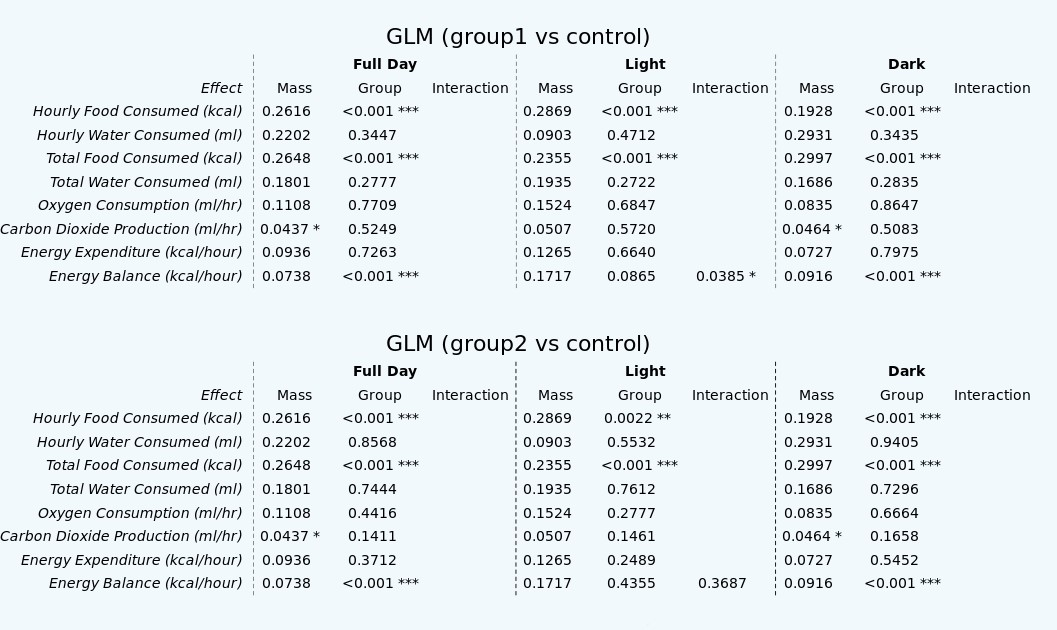

In [233]:
# need to check if the values of calr and incal are have same diff in each 
glm_photo

In [237]:
calr_ave_file['Energy_Balance'].values / analysis_format_calculeted['Energy_Balance'].values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [238]:
ancova(calr_ave_file, 'Energy_Balance', 'Total_Mass', 'Group')

Intercept          1.220444e-03
C(Group)[T.HET]    3.333238e-10
C(Group)[T.KO]     2.833509e-09
Total_Mass         2.519868e-01
dtype: float64

In [239]:
ancova(analysis_format_calculeted.reset_index(), 'Energy_Balance', 'bodymass', 'Group')

Intercept              1.220444e-03
C(Group)[T.Group_2]    3.333238e-10
C(Group)[T.Group_3]    2.833509e-09
bodymass               2.519868e-01
dtype: float64

In [184]:
# Energy_Expenditure
calr_ave_file['Energy_Expenditure'].values / analysis_format_calculeted.kcal_hr.values


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [185]:
ancova(calr_ave_file, 'Energy_Expenditure', 'Total_Mass', 'Group')


Intercept          0.517679
C(Group)[T.HET]    0.712645
C(Group)[T.KO]     0.360449
Total_Mass         0.096495
dtype: float64

In [186]:
ancova(analysis_format_calculeted.reset_index(), 'kcal_hr', 'bodymass', 'Group')

Intercept              0.517679
C(Group)[T.Group_2]    0.712645
C(Group)[T.Group_3]    0.360449
bodymass               0.096495
dtype: float64

In [175]:
# Oxygen_Consumption
calr_ave_file['Oxygen_Consumption'].values / analysis_format_calculeted.vo2.values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [176]:
ancova(calr_ave_file, 'Oxygen_Consumption', 'Total_Mass', 'Group')

Intercept          0.530093
C(Group)[T.HET]    0.757346
C(Group)[T.KO]     0.429935
Total_Mass         0.113880
dtype: float64

In [177]:
ancova(analysis_format_calculeted.reset_index(), 'vo2', 'bodymass', 'Group')

Intercept              0.530093
C(Group)[T.Group_2]    0.757346
C(Group)[T.Group_3]    0.429935
bodymass               0.113880
dtype: float64

In [169]:
# Carbon_Dioxide_Production
calr_ave_file['Carbon_Dioxide_Production'].values / analysis_format_calculeted.vco2.values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [170]:
ancova(calr_ave_file, 'Carbon_Dioxide_Production', 'Total_Mass', 'Group')

Intercept          0.474002
C(Group)[T.HET]    0.512647
C(Group)[T.KO]     0.135933
Total_Mass         0.045888
dtype: float64

In [171]:
ancova(analysis_format_calculeted.reset_index(), 'vco2', 'bodymass', 'Group')

Intercept              0.474002
C(Group)[T.Group_2]    0.512647
C(Group)[T.Group_3]    0.135933
bodymass               0.045888
dtype: float64

In [156]:
# there is problem with ancova and anova with inte.. in the Cumulative calc (I do not understend what the values they put to get this result)
calr_ave_file['Cumulative_Food_Intake'].values / analysis_format_calculeted.actual_foodupa.values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [157]:
ancova(calr_ave_file, 'Cumulative_Food_Intake', 'Total_Mass', 'Group')

Intercept          1.196512e-03
C(Group)[T.HET]    3.279599e-10
C(Group)[T.KO]     2.776575e-09
Total_Mass         2.575933e-01
dtype: float64

In [158]:
anova_with_interaction(calr_ave_file, 'Cumulative_Food_Intake', 'Total_Mass', 'Group')

Intercept                     0.009254
C(Group)[T.HET]               0.037774
C(Group)[T.KO]                0.037921
Total_Mass                    0.073099
Total_Mass:C(Group)[T.HET]    0.157073
Total_Mass:C(Group)[T.KO]     0.150091
dtype: float64

In [159]:
ancova(analysis_format_calculeted.reset_index(), 'actual_foodupa', 'bodymass', 'Group')

Intercept              1.196512e-03
C(Group)[T.Group_2]    3.279599e-10
C(Group)[T.Group_3]    2.776575e-09
bodymass               2.575933e-01
dtype: float64

In [160]:
anova_with_interaction(analysis_format_calculeted.reset_index(), 'actual_foodupa', 'bodymass', 'Group')

Intercept                       0.009254
C(Group)[T.Group_2]             0.037774
C(Group)[T.Group_3]             0.037921
bodymass                        0.073099
bodymass:C(Group)[T.Group_2]    0.157073
bodymass:C(Group)[T.Group_3]    0.150091
dtype: float64

In [165]:
calr_ave_file['Cumulative_Water_Intake'].values / analysis_format_calculeted.actual_waterupa.values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [167]:
anova_with_interaction(analysis_format_calculeted.reset_index(), 'actual_waterupa', 'bodymass', 'Group')
ancova(analysis_format_calculeted.reset_index(), 'actual_waterupa', 'bodymass', 'Group')

Intercept              0.417694
C(Group)[T.Group_2]    0.342407
C(Group)[T.Group_3]    0.857267
bodymass               0.221694
dtype: float64

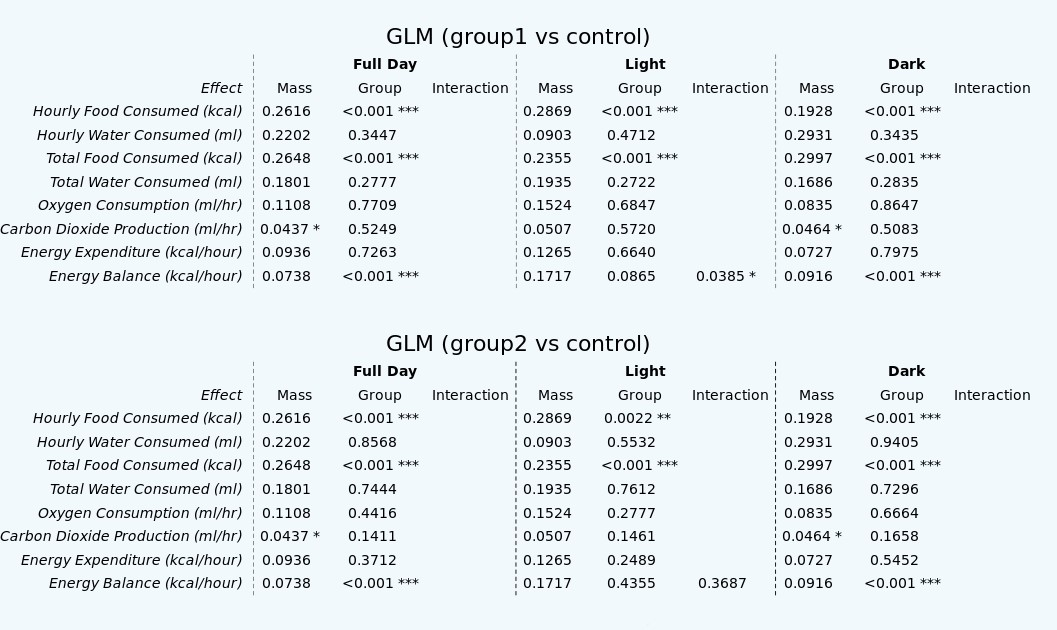

In [161]:
glm_photo

In [150]:
calr_ave_file['Cumulative_Water_Intake'].values / analysis_format_calculeted.actual_waterupa.values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [151]:
ancova(calr_ave_file, 'Cumulative_Water_Intake', 'Total_Mass', 'Group')

Intercept          0.417694
C(Group)[T.HET]    0.342407
C(Group)[T.KO]     0.857267
Total_Mass         0.221694
dtype: float64

In [152]:
anova_with_interaction(calr_ave_file, 'Cumulative_Water_Intake', 'Total_Mass', 'Group')

Intercept                     0.441675
C(Group)[T.HET]               0.410534
C(Group)[T.KO]                0.222905
Total_Mass                    0.541972
Total_Mass:C(Group)[T.HET]    0.387285
Total_Mass:C(Group)[T.KO]     0.218656
dtype: float64

In [154]:
ancova(analysis_format_calculeted.reset_index(), 'actual_waterupa', 'bodymass', 'Group')

Intercept              0.417694
C(Group)[T.Group_2]    0.342407
C(Group)[T.Group_3]    0.857267
bodymass               0.221694
dtype: float64

In [155]:
anova_with_interaction(analysis_format_calculeted.reset_index(), 'actual_waterupa', 'bodymass', 'Group')

Intercept                       0.441675
C(Group)[T.Group_2]             0.410534
C(Group)[T.Group_3]             0.222905
bodymass                        0.541972
bodymass:C(Group)[T.Group_2]    0.387285
bodymass:C(Group)[T.Group_3]    0.218656
dtype: float64

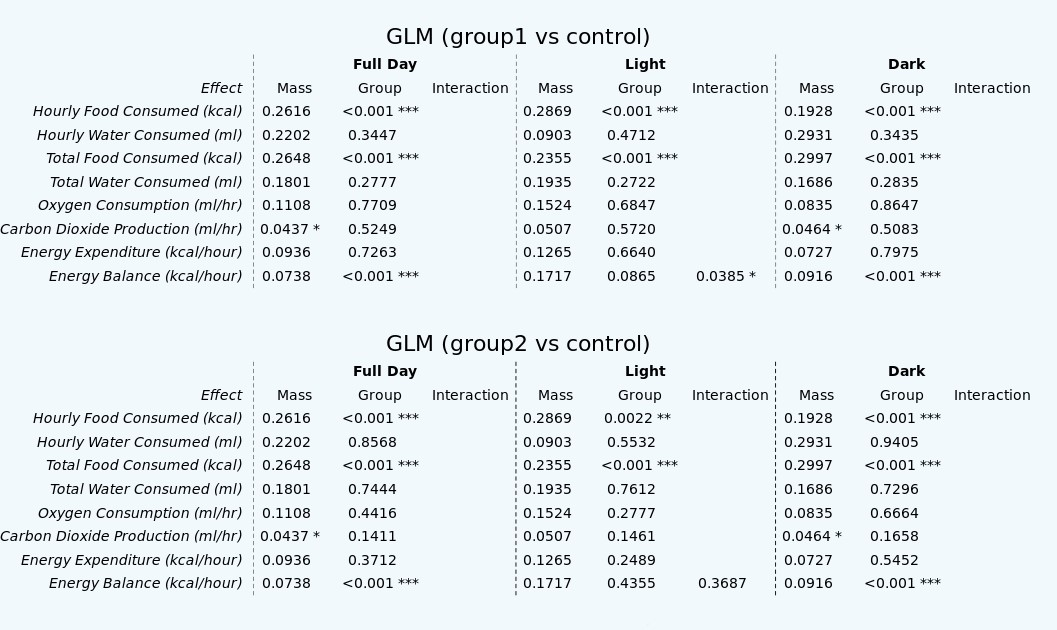

In [145]:
glm_photo

In [113]:
anova(analysis_format_calculeted.reset_index(), 'rq', 'Group')# 6.46849-01, 101424-1

Intercept              2.689198e-17
C(Group)[T.Group_2]    6.468490e-01
C(Group)[T.Group_3]    1.014246e-01
dtype: float64

In [114]:
anova(calr_ave_file, 'Respiratory_Exchange_Ratio', 'Group')

Intercept          2.689198e-17
C(Group)[T.HET]    6.468490e-01
C(Group)[T.KO]     1.014246e-01
dtype: float64

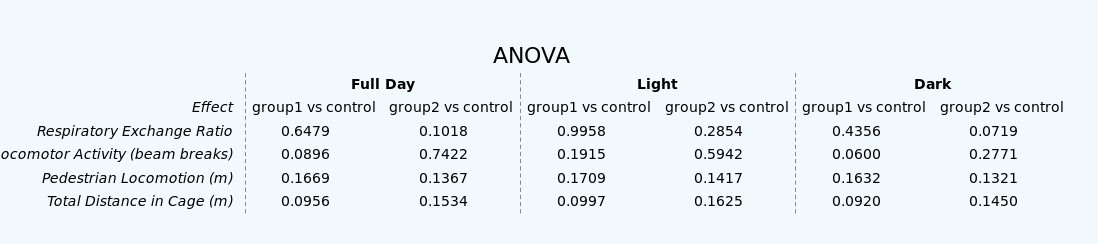

In [115]:
img

In [116]:
anova(analysis_format_calculeted.reset_index(), 'locomotor_activity', 'Group')

Intercept              5.967005e-07
C(Group)[T.Group_2]    9.441315e-02
C(Group)[T.Group_3]    7.854597e-01
dtype: float64

In [117]:
anova(calr_ave_file, 'Locomotor_Activity', 'Group')

Intercept          5.967005e-07
C(Group)[T.HET]    9.441315e-02
C(Group)[T.KO]     7.854597e-01
dtype: float64

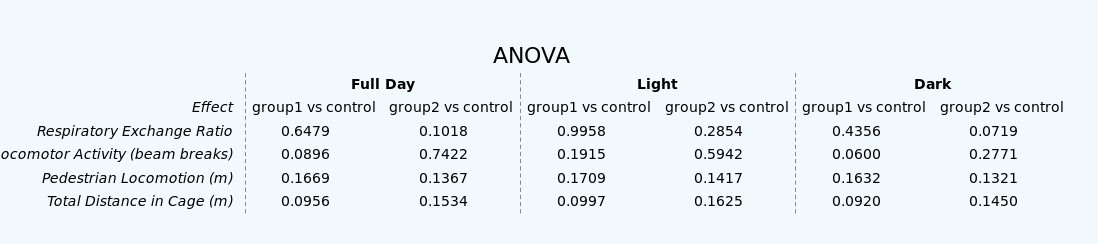

In [118]:
img

In [119]:
# THE ANOVA WITH LOCOMO.. IS WORNG SO I CHECK THE ORIGINAL DATA TO SEE THE DIFFRENS

In [120]:
analysis_format_calculeted.locomotor_activity.head(5)

subjectID  Group  
1          Control    359.007194
4          Control    281.028777
7          Control    250.690647
10         Control    205.125899
13         Control    167.992806
Name: locomotor_activity, dtype: float64

In [121]:
calr_ave_file[['Locomotor_Activity', 'Subject_ID']].head(5)

,Locomotor_Activity,Subject_ID
0,359.007194,1
3,281.028777,4
6,250.690647,7
9,205.125899,10
12,167.992806,13


In [122]:
resampled_analysis_format_means.reset_index().sort_values(['subjectID', 'Date_Time_1']).locomotor_activity.head(3)

0     201.000000
16    513.666667
32    381.666667
Name: locomotor_activity, dtype: float64

In [123]:
calr_timeseries[['Subject_ID', 'Locomotor_Activity']].head(3)

,Subject_ID,Locomotor_Activity
12,1,201.000000
13,1,513.666667
14,1,381.666667


In [124]:
# Pedestrian_Locomotion
calr_timeseries

,Unnamed:_0,Subject_ID,Group,Time_of_Day,Hourly_Food_Intake,Hourly_Water_Intake,Cumulative_Food_Intake,Cumulative_Water_Intake,Oxygen_Consumption,Carbon_Dioxide_Production,Energy_Expenditure,Respiratory_Exchange_Ratio,Locomotor_Activity,Pedestrian_Locomotion,Total_Distance_(includes_fine_movement),Hour,Day,Energy_Balance,Total.Mass
12,13,1,WT,1,0.000000,0.000000,0.000000,0.000000,85.280940,64.866900,0.407835,0.758679,201.000000,0.000000,0.000000,0,0,-0.407835,24.465640
13,14,1,WT,1,0.956338,0.000482,0.956338,0.000482,108.171000,90.460200,0.526351,0.833356,513.666667,3.029568,4.428044,1,0,0.429987,24.456993
14,15,1,WT,1,1.034333,0.120672,1.990671,0.121155,108.833900,93.368060,0.532180,0.857264,381.666667,12.264161,16.296653,2,0,0.502154,24.476997
0,1,1,WT,0,0.635888,0.196626,2.626558,0.317780,105.855660,91.920800,0.518842,0.868751,722.333333,22.910176,29.528890,3,0,0.117046,25.102320
1,2,1,WT,0,0.203176,0.039062,2.829734,0.356842,93.647420,83.124520,0.461000,0.885954,187.000000,30.863960,39.752703,4,0,-0.257824,24.619040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405,1406,15,KO,1,0.000000,0.002694,15.174525,7.953687,55.669842,43.467858,0.267470,0.778811,170.000000,580.058916,744.924264,89,4,-0.267470,24.601870
1406,1407,15,KO,1,0.000000,0.002961,15.174525,7.956648,63.944582,48.041478,0.305139,0.615736,304.666667,583.187016,749.062130,90,4,-0.305139,24.601870
1407,1408,15,KO,1,0.000000,0.000000,15.174525,7.956648,48.977184,35.749004,0.232558,0.730291,12.666667,586.909983,753.883997,91,4,-0.232558,24.601870
1408,1409,15,KO,1,0.000000,0.000000,15.174525,7.956648,57.205908,43.034286,0.273044,0.748222,74.333333,587.861250,755.266164,92,4,-0.273044,24.601870


In [125]:
# Pedestrian_Locomotion
calr_ave_file[['Subject_ID', 'Pedestrian_Locomotion']].head(2)

,Subject_ID,Pedestrian_Locomotion
0,1,327.708630
3,4,201.510676


In [126]:
analysis_format_calculeted.actual_pedmeters_cumsum.values / calr_ave_file.Pedestrian_Locomotion.values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [127]:
anova(analysis_format_calculeted.reset_index(), 'actual_pedmeters_cumsum', 'Group')

Intercept              0.000069
C(Group)[T.Group_2]    0.160939
C(Group)[T.Group_3]    0.135979
dtype: float64

In [128]:
anova(calr_ave_file, 'Pedestrian_Locomotion', 'Group')

Intercept          0.000069
C(Group)[T.HET]    0.160939
C(Group)[T.KO]     0.135979
dtype: float64

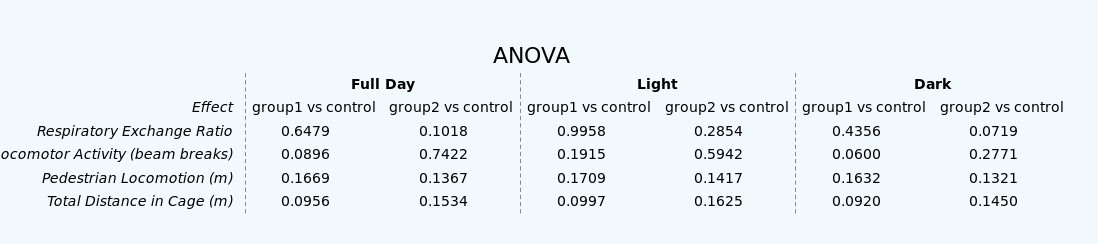

In [129]:
img

In [130]:
# total_distance_in_cage (m)
calr_ave_file['Total_Distance'].values / analysis_format_calculeted['actual_allmeters_cumsum'].values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [131]:
anova(analysis_format_calculeted.reset_index(), 'actual_allmeters_cumsum', 'Group')

Intercept              0.000008
C(Group)[T.Group_2]    0.093543
C(Group)[T.Group_3]    0.152740
dtype: float64

In [132]:

anova(calr_ave_file, 'Total_Distance', 'Group')

Intercept          0.000008
C(Group)[T.HET]    0.093543
C(Group)[T.KO]     0.152740
dtype: float64

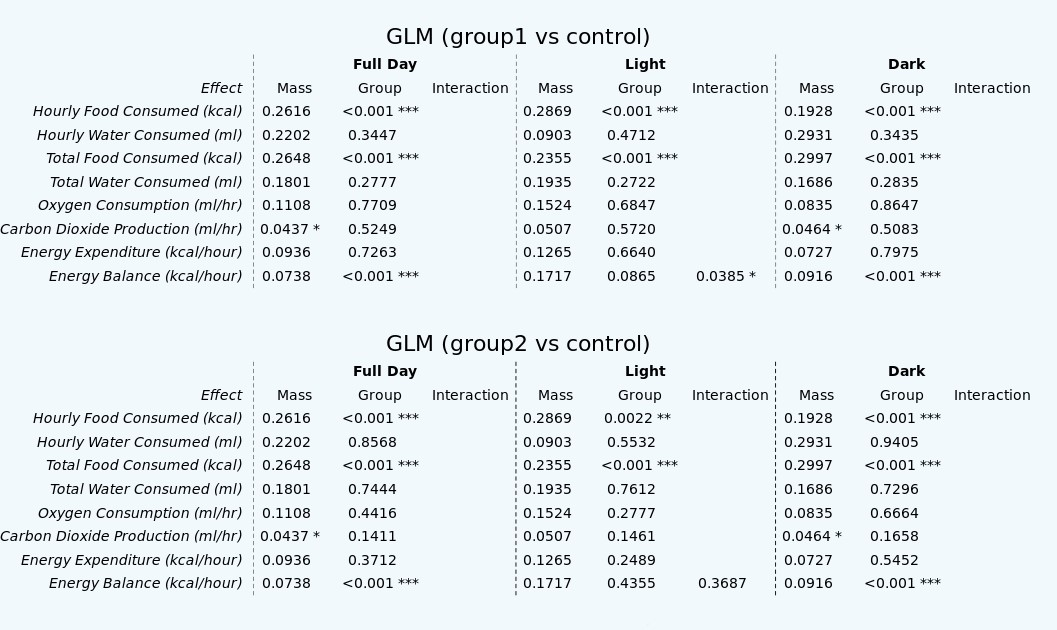

In [133]:
glm_photo

In [134]:
# Hourly_Water_Intake
calr_ave_file['Hourly_Water_Intake'].values / analysis_format_calculeted.actual_waterupa.values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [135]:
ancova(calr_ave_file, 'Hourly_Water_Intake', 'Total_Mass', 'Group')

Intercept          0.417694
C(Group)[T.HET]    0.342407
C(Group)[T.KO]     0.857267
Total_Mass         0.221694
dtype: float64

In [136]:
anova_with_interaction(calr_ave_file, 'Hourly_Water_Intake', 'Total_Mass', 'Group')

Intercept                     0.441675
C(Group)[T.HET]               0.410534
C(Group)[T.KO]                0.222905
Total_Mass                    0.541972
Total_Mass:C(Group)[T.HET]    0.387285
Total_Mass:C(Group)[T.KO]     0.218656
dtype: float64

In [137]:
ancova(analysis_format_calculeted.reset_index(), 'actual_waterupa', 'bodymass', 'Group')

Intercept              0.417694
C(Group)[T.Group_2]    0.342407
C(Group)[T.Group_3]    0.857267
bodymass               0.221694
dtype: float64

In [138]:
anova_with_interaction(analysis_format_calculeted.reset_index(), 'actual_waterupa', 'bodymass', 'Group')

Intercept                       0.441675
C(Group)[T.Group_2]             0.410534
C(Group)[T.Group_3]             0.222905
bodymass                        0.541972
bodymass:C(Group)[T.Group_2]    0.387285
bodymass:C(Group)[T.Group_3]    0.218656
dtype: float64

In [139]:
# Hourly_Food_Intake
calr_ave_file.Hourly_Food_Intake.values / analysis_format_calculeted.actual_foodupa.values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [140]:
ancova(calr_ave_file, 'Hourly_Food_Intake', 'Total_Mass', 'Group')

Intercept          1.196512e-03
C(Group)[T.HET]    3.279599e-10
C(Group)[T.KO]     2.776575e-09
Total_Mass         2.575933e-01
dtype: float64

In [141]:
anova_with_interaction(calr_ave_file, 'Hourly_Food_Intake', 'Total_Mass', 'Group')

Intercept                     0.009254
C(Group)[T.HET]               0.037774
C(Group)[T.KO]                0.037921
Total_Mass                    0.073099
Total_Mass:C(Group)[T.HET]    0.157073
Total_Mass:C(Group)[T.KO]     0.150091
dtype: float64

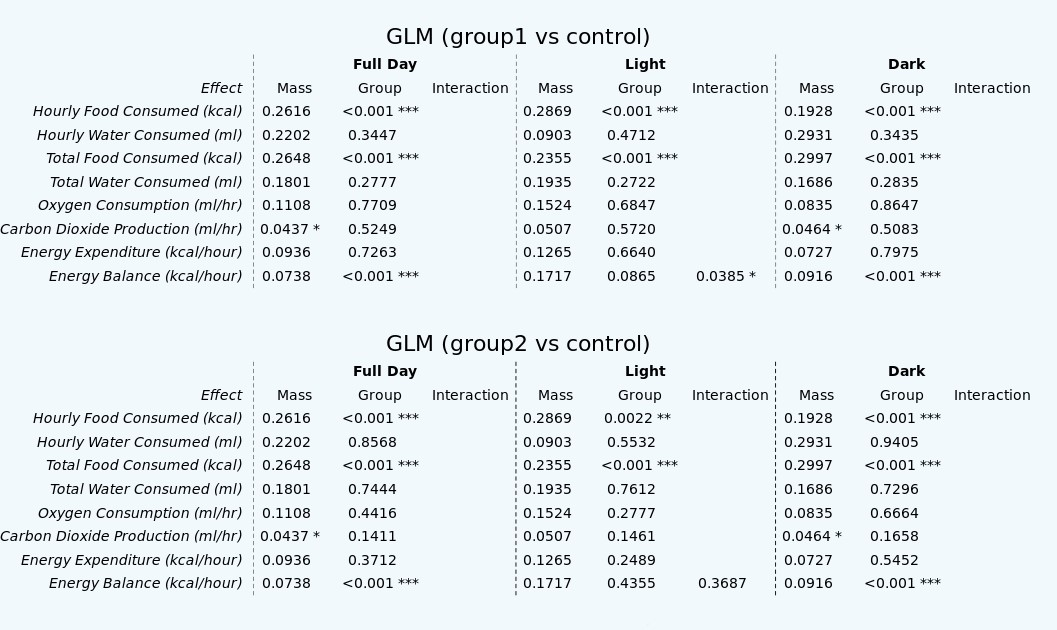

In [142]:
glm_photo

In [ ]:
array = np.array([
  [8, 9, 5, 7, 6, 10, 8, 4],
  [2, 5, 6, 7, 5, 4, 3, 1],
  [7, 5, 2, 1, 7, 6, 4, 2]]
  )

In [ ]:
s = array * array

In [ ]:
ss = np.sum(s, axis=1)

In [ ]:
ss / s.shape[0]

array([145.        ,  55.        ,  61.33333333])